# Setup

In [1]:
import sklearn
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Fetch, Load

In [74]:
from sklearn.datasets import fetch_openml

In [75]:
mnist = fetch_openml('mnist_784', version = 1)

In [76]:
print(mnist.keys())
print(mnist.data)
print(mnist.target)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['5' '0' '4' ... '4' '5' '6']


In [77]:
print(mnist.data.shape) #28*28 pixel ( = 784 features)
print(mnist.target.shape) #labels
X = mnist.data
y = mnist.target

(70000, 784)
(70000,)


In [78]:
random_digit = X[807]
random_digit_image = random_digit.reshape(28,28)

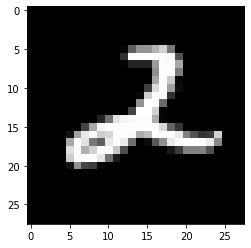

In [80]:
plt.imshow(random_digit_image, cmap = 'gray', interpolation = 'nearest')
plt.show()

In [82]:
y[807]

'2'

In [83]:
y.dtype

dtype('O')

In [84]:
y = y.astype(np.uint8) #changing datatype

# Train, Test Split

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training Binary Classifier 

In [10]:
y_train_2 = (y_train == 2)
y_test_2 = (y_test == 2)

In [11]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state =42)
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([random_digit])

array([False])

# Evaluating Performance of Classifier

#### Cross Validation (Accuracy)

In [13]:
# 간단한 Cross Validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, X_train, y_train_2, cv=5) 

print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.96175319 0.95008749 0.95983333 0.97499792 0.96858072]
cross-val-score.mean 
0.963


In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_2):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_2[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_2[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96645
0.95895
0.904


#### Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_2, cv = 3)
y_train_predict

array([False, False, False, ..., False, False, False])

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_2, y_train_predict)

array([[51538,  2504],
       [  908,  5050]])

In [17]:
perfect_prediction = y_train_2
confusion_matrix(y_train_2, perfect_prediction)

array([[54042,     0],
       [    0,  5958]])

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_2, y_train_predict))
print(recall_score(y_train_2, y_train_predict))

0.6685199894095843
0.8475998657267539


In [19]:
5050 / (2504 + 5050) # True Positive / (True Positive + False Positive)

0.6685199894095843

In [20]:
5050 / (908 + 5050) # True Positive / (True Positive + False Negative)

0.8475998657267539

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_2, y_train_predict)

0.7474837181764358

In [22]:
5050 / (5050 + (908 + 2504)/2)

0.7474837181764358

#### Trade-off: Precision & Recall

In [23]:
#decision score
decision_scores = sgd_clf.decision_function([random_digit])
decision_scores

array([-388.95172476])

In [24]:
threshold = -500
random_digit_pred = (decision_scores > threshold)
random_digit_pred

array([ True])

In [25]:
threshold = 1000
random_digit_pred = (decision_scores > threshold)
random_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,
                             method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

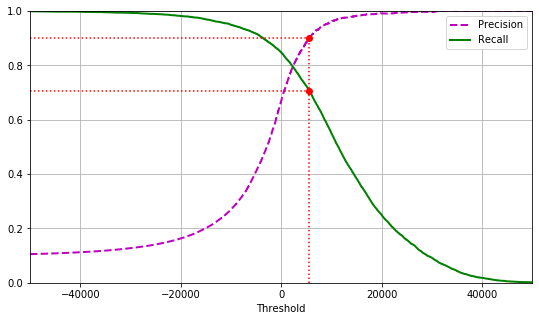

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "m--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="upper right") 
    plt.xlabel("Threshold")        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(9, 5))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

5585.140261597365

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_2, y_train_pred_90)

0.9000641985876311

In [32]:
recall_score(y_train_2, y_train_pred_90)

0.7059415911379657

#### ROC Curve

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

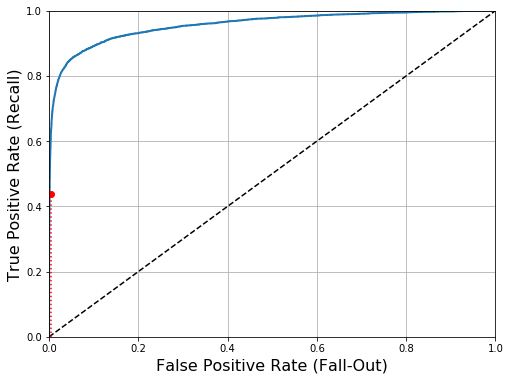

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")                                    
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_2, y_scores)

0.9568395257681235

# Multi-class classification

In [37]:
# SGDClassifier를 이용한 multi-class classification
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([random_digit])

array([2], dtype=uint8)

In [44]:
random_digit_scores = sgd_clf.decision_function([random_digit])
random_digit_scores

array([[-17779.73051192, -22219.43679105,   2186.23451143,
          -854.04333925,  -1783.27522655, -11066.62275567,
        -19790.23958332, -18357.20455282,  -1279.77205808,
         -8130.26103567]])

In [45]:
np.argmax(random_digit_scores)

2

In [46]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
sgd_clf.classes_[2]

2

In [38]:
# OVA 가 디폴트지만 OVO 를 굳이 쓰고 싶다면?
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([random_digit])

array([2], dtype=uint8)

In [50]:
len(ovo_clf.estimators_)

45

In [49]:
random_digit_scores = ovo_clf.decision_function([random_digit])
random_digit_scores

array([[3.66666737, 0.66666696, 9.33333308, 5.33333288, 8.33333296,
        2.66666747, 7.33333249, 1.66666781, 3.66666758, 1.66666716]])

In [41]:
# random forest - 'direct' classification
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3,
                                    method="predict_proba")

In [42]:
forest_clf. fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
forest_clf.predict_proba([random_digit])

array([[0.  , 0.02, 0.92, 0.02, 0.02, 0.  , 0.  , 0.01, 0.01, 0.  ]])

In [53]:
# 성능 평가
scores = cross_val_score(sgd_clf, X_train, y_train, cv =3, scoring = 'accuracy')

print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.87082583 0.87089354 0.88628294]
cross-val-score.mean 
0.876


In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scaled_scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv =3, scoring = 'accuracy')

print('cross-val-score \n{}'.format(scaled_scores))
print('cross-val-score.mean \n{:.3f}'.format(scaled_scores.mean()))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


cross-val-score 
[0.89957009 0.89344467 0.89963495]
cross-val-score.mean 
0.898


# Error Analysis

In [59]:
# confusion matrix - 어디서, 어떤 에러가 발생했는지 확인 가능
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

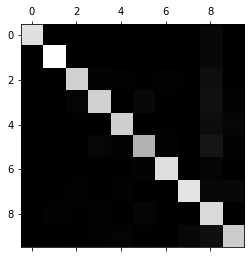

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

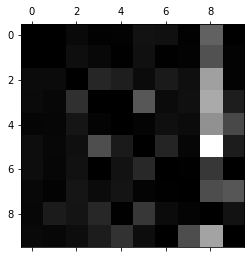

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

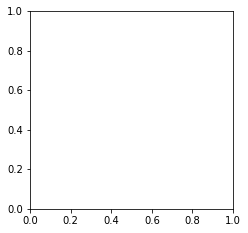

In [92]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification

In [66]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [67]:
knn_clf.predict([random_digit])

array([[False, False]])

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

In [88]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

NameError: name 'plot_digit' is not defined

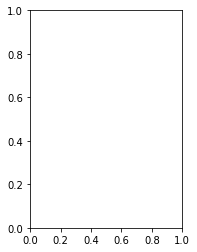

In [90]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [93]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

NameError: name 'plot_digit' is not defined